In [9]:
#Qiskit Machine Learning
#qGANs for Loading Random Distributions

#Given k-dimensional data samples, we employ a quantum Generative Adversarial Network (qGAN) to learn the data’s underlying random distribution 
#and to load it directly into a quantum state:
#The aim of the qGAN training is to generate a state ∣∣gθ⟩, where pjθ, for j∈{0,…,2n−1}, 
#describe a probability distribution that is close to the distribution underlying the training data X={x0,…,xk−1}
import numpy as np
seed = 71
np.random.seed = seed

import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import QuantumRegister, QuantumCircuit, BasicAer
from qiskit.circuit.library import TwoLocal, UniformDistribution

from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import QGAN
from qiskit.aqua.components.neural_networks import NumPyDiscriminator
import time

aqua_globals.random_seed = seed

In [2]:
#Load Training Data
#First, we need to load the k-dimensional training data samples (here k=2).

# Number training data samples
N = 1000

# Load data samples from log-normal distribution with mean=1 and standard deviation=1
mu = 1
sigma = 1
real_data = np.random.lognormal(mean = mu, sigma=sigma, size=N)
real_data = [[x, int(x/2) if (x>5) else int(x)] for x in real_data ]
real_data = np.asarray(real_data)
print (real_data)
print (len(real_data))
print(real_data.shape)
print(real_data[:,0].min(),real_data[:,0].max(),real_data[:,1].min(),real_data[:,1].max())

#Next, the data resolution is set, i.e. 
#the min/max data values and the number of qubits used to represent each data dimension.
# Set the data resolution
# Set upper and lower data values as list of k min/max data values [[min_0,max_0],...,[min_k-1,max_k-1]]
bounds = [[0.,33.],[0.,16.]]
bounds = np.asarray(bounds)
print (bounds)
# Set number of qubits per data dimension as list of k qubit values[#q_0,...,#q_k-1]
num_qubits = [2,1]
k = len(num_qubits)

[[ 5.15831603  2.        ]
 [10.12763632  5.        ]
 [ 0.99567787  0.        ]
 ...
 [13.19660532  6.        ]
 [ 1.88529335  1.        ]
 [ 0.99497957  0.        ]]
1000
(1000, 2)
0.02952437252011121 85.36646716592162 0.0 42.0
[[ 0. 33.]
 [ 0. 16.]]


In [6]:
#Initialize the qGAN
#The qGAN consists of a quantum generator, a variational quantum circuit, and a classical discriminator,
#a neural network.
#To implement the quantum generator, we choose a depth-1 variational form that implements 
#R_Y rotations and CZ gates which takes a uniform distribution as an input state. 
#Notably, for k > 1 the generator's parameters must be chosen carefully. 
#For example, the circuit depth should be > 1 
#because higher circuit depths enable the representation of more complex structures.
#The classical discriminator is given by a 3-layer neural network that applies linear transformations, 
#leaky ReLU functions in the hidden layers and a sigmoid function in the output layer. 
#Notably, the neural network is implemented with PyTorch. 
#Please refer to https://pytorch.org/get-started/locally/ for PyTorch installation instructions.
#Here, both networks are updated with the ADAM optimization algorithm.

# Set number of training epochs - # of times training process should run
# Note: The algorithm's runtime can be shortened by reducing the number of training epochs.
num_epochs = 100
# Batch size
batch_size = 100

 # Initialize qGAN
qgan = QGAN(real_data, bounds, num_qubits, batch_size, num_epochs, snapshot_dir=None)
qgan.seed = 1
print(qgan)
# Set quantum instance to run the quantum generator
quantum_instance = QuantumInstance(backend=BasicAer.get_backend('statevector_simulator'),
                                   seed_transpiler=seed, seed_simulator=seed)

# Set entangler map
entangler_map = [[0, 1],[1,2]]  #Since we are using only two qubits

# Set an initial state for the generator circuit
#init_state = UniformDistribution(sum(num_qubits), low=bounds[0], high=bounds[1])
init_state = UniformDistribution(sum(num_qubits))
# Set the ansatz circuit
var_form = TwoLocal(int(np.sum(num_qubits)), 'ry', 'cz', entanglement=entangler_map, reps=1)

# Set generator circuit by adding the initial distribution infront of the ansatz
q = QuantumRegister(sum(num_qubits), name='q')
qc = var_form.compose(init_state, front=True)
#qc.draw(output='mpl')
qc.draw()

┌───┐┌──────────┐   ┌──────────┐            
q_0: ┤ H ├┤ RY(θ[0]) ├─■─┤ RY(θ[3]) ├────────────
     ├───┤├──────────┤ │ └──────────┘┌──────────┐
q_1: ┤ H ├┤ RY(θ[1]) ├─■──────■──────┤ RY(θ[4]) ├
     ├───┤├──────────┤        │      ├──────────┤
q_2: ┤ H ├┤ RY(θ[2]) ├────────■──────┤ RY(θ[5]) ├
     └───┘└──────────┘               └──────────┘

In [5]:
#Create an Initial Distribution from the circuit
init_distribution = Custom(num_qubits=sum(num_qubits), circuit=qc)
#Setup the variational form
var_form = RY(int(np.sum(num_qubits)), depth=1, initial_state = init_distribution, 
              entangler_map=entangler_map, entanglement_gate='cz')
# Set generator's initial parameters
init_params = aqua_globals.random.rand(var_form._num_parameters) * 2 * np.pi
# Set generator circuit
g_circuit = MultivariateVariationalDistribution(num_qubits, var_form, init_params,low=bounds[:,0], high=bounds[:,1])

<ipython-input-5-bd8d734b5f41>:4: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  var_form = RY(int(np.sum(num_qubits)), depth=1, initial_state = init_distribution,


AttributeError: 'numpy.random._generator.Generator' object has no attribute 'rand'

In [18]:
print(init_distribution)
print(var_form)
print(init_params)
print(g_circuit)

[2.62022653e+00 4.52593227e+00 7.18638172e-04 1.89961158e+00
 9.22094457e-01 5.80180502e-01]


In [11]:
# Set generator's initial parameters - in order to reduce the training time and hence the
# total running time for this notebook
#init_params = [3., 1., 0.6, 1.6]
# You can increase the number of training epochs and use random initial parameters.
init_params = np.random.rand(var_form.num_parameters_settable) * 2 * np.pi

# Set quantum generator
qgan.set_generator(generator_circuit=qc, generator_init_params=init_params)
# The parameters have an order issue that following is a temp. workaround
qgan._generator._free_parameters = sorted(qc.parameters, key=lambda p: p.name)
# Set classical discriminator neural network
discriminator = NumPyDiscriminator(len(num_qubits))
qgan.set_discriminator(discriminator)

print(qgan)

E:\DevelopmentEnvironments\Anaconda3\envs\qiskit_env\lib\site-packages\qiskit\aqua\components\neural_networks\quantum_generator.py:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self._data_grid = np.array(self._data_grid)


In [16]:
#Run the qGAN Training
#During the training the discriminator's and the generator's parameters are updated alternately 
#w.r.t the following loss functions: 
#$$ L_G\left(\phi, \theta\right) = -\frac{1}{m}\sum\limits_{l=1}^{m}\left[\log\left(D_{\phi}\left(g^{l}\right)\right)\right] $$ and $$ L_D\left(\phi, \theta\right) = \frac{1}{m}\sum\limits_{l=1}^{m}\left[\log D_{\phi}\left(x^{l}\right) + \log\left(1-D_{\phi}\left(g^{l}\right)\right)\right], $$ with $m$ denoting the batch size and $g^l$ describing the data samples generated by the quantum generator.

# Run qGAN
start = time.time()
result = qgan.run(quantum_instance)
# Runtime
end = time.time()
print('qGAN training runtime: ', (end - start)/60., ' min')

qGAN training runtime:  2.0790711005528766  min


ValueError: x and y must have same first dimension, but have shapes (100,) and (200, 1)

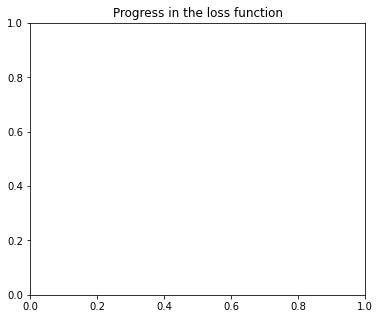

In [18]:
#Training Progress & Outcome
#Now, we plot the evolution of the generator's and the discriminator's loss functions 
#during the training as well as the progress in the relative entropy between the trained and the target distribution.
#Finally, we also compare the cumulative distribution function (CDF) of the trained distribution 
#to the CDF of the target distribution.

# Plot progress w.r.t the generator's and the discriminator's loss function
t_steps = np.arange(num_epochs)
plt.figure(figsize=(6,5))
plt.title("Progress in the loss function")
plt.plot(t_steps, qgan.g_loss, label = "Generator loss function", color = 'mediumvioletred', linewidth = 2)
plt.plot(t_steps, qgan.d_loss, label = "Discriminator loss function", color = 'rebeccapurple', linewidth = 2)
plt.grid()
plt.legend(loc = 'best')
plt.xlabel('time steps')
plt.ylabel('loss')
plt.show()

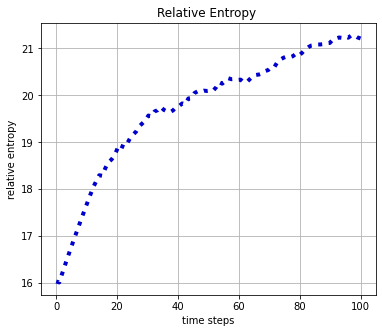

In [14]:
# Plot progress w.r.t relative entropy
plt.figure(figsize=(6,5))
plt.title("Relative Entropy ")
plt.plot(np.linspace(0, num_epochs, len(qgan.rel_entr)), qgan.rel_entr, color ='mediumblue', lw=4, ls=':')
plt.grid()
plt.xlabel('time steps')
plt.ylabel('relative entropy')
plt.show()

In [15]:
#Plot the PDF of the resulting distribution against the target distribution, i.e. log-normal
log_normal = np.random.lognormal(mean=1, sigma=1, size=100000)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= bounds[1]]
temp = []
for i in range(int(bounds[1]+1)):
    temp += [np.sum(log_normal==i)]
log_normal = np.array(temp / sum(temp))

plt.figure(figsize=(6,5))
plt.title("CDF")
samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=10000)
samples_g = np.array(samples_g)
samples_g = samples_g.flatten()
num_bins = len(prob_g)
plt.bar(samples_g,  np.cumsum(prob_g), color='royalblue', width= 0.8, label='simulation')
plt.plot( np.cumsum(log_normal),'-o', label='log-normal', color='deepskyblue', linewidth=4, markersize=12)
plt.xticks(np.arange(min(samples_g), max(samples_g)+1, 1.0))
plt.grid()
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend(loc='best')
plt.show()

ValueError: operands could not be broadcast together with shapes (100000,) (2,) 